# Modularity

In this notebook, we will calculate the modularity of each graph.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from matplotlib.lines import Line2D

from graph import GraphIO
from graspologic.utils import symmetrize, to_weighted_edge_list
from graspologic.partition import leiden, modularity

from c_elegans.witvilet2020.load_wit import load_wit
from c_elegans.worm_wiring.load_worm import load_worm

%matplotlib inline

Load graphs

In [2]:
worm_graphs = load_worm()
wit_graphs = load_wit()
worm_connectomes = worm_graphs[6:12]

In [3]:
neuPrint = './json_connectomes/neuPrint_graphs.json'
fafb = './json_connectomes/fafb.json'
ciona = './json_connectomes/ciona.json'
G_neuP, _, _, _ = GraphIO.load(neuPrint)
G_fafb, _, _, _ = GraphIO.load(fafb)
G_ciona, _, _, _ = GraphIO.load(ciona)

Change the graph nodes which are in type int to type str

In [4]:
def nodes_to_string(G):
    '''
    Given a netwrokx graph, convert the nodes into str type.
    '''
    str_nodes = []
    for i in G.nodes:
        new_node = str(i)
        str_nodes.append(new_node)
    mapping = dict(zip(G, str_nodes))
    graph_str = nx.relabel_nodes(G, mapping)
    return graph_str

In [5]:
G_neuP_str = nodes_to_string(G_neuP)
G_fafb_str = nodes_to_string(G_fafb)

Change the directed graphs into undirected by reform the graph with newly weighted edges. The new weight is define as the average weight between two nodes.

In [6]:
def average_undirect(G):
    G_undirect = nx.Graph()
    G_un = []
    nodes_list = []
    for (u, v, wt) in G.edges.data('weight'):
        for (ui, vi, wti) in G.edges.data('weight'):
            if vi == u and ui == v:
                n_a = u
                n_b = v
                new_wt = (wt+wti)/2
                if (n_a, n_b) not in nodes_list:
                    nodes_list.append((n_a, n_b))
                    G_un.append((n_a, n_b, new_wt))
    G_undirect.add_weighted_edges_from(G_un)
    return G_undirect

In [7]:
def modulate_graphs(G):
    '''
    Given the networkx graph, return the modularity of each graph.
    '''
    if type(G) is nx.MultiDiGraph:
        G = G.to_undirected()
        G = GraphIO.multigraph_to_graphs(G)
        leids = []
        ms = []
        for g in G:
            leiden_g = leiden(g)
            leids.append(leiden_g)
            m = modularity(g,leiden_g)
            ms.append(m)
        return ms
    if type(G) is nx.DiGraph:
        G = G.to_undirected()
        leiden_g = leiden(G)
        m = modularity(G,leiden_g)
        return m
    else:
        leiden_g = leiden(G)
        m = modularity(G,leiden_g)
        return m

Use the same method in Graph Stats.ipynb developed by Paul to visualize the result.

In [8]:
fafb_graph = G_fafb_str
neuPrint_graph = G_neuP_str
ciona_graph = G_ciona
ciona_graph.graph["Sex"] = "Hermaphrodite"
ciona_graph.graph["synapse_type"] = "Mixed"
fafb_graph.graph["Sex"] = "Female"
fafb_graph.graph["synapse_type"] = "Chemical"
neuPrint_graph.graph["Sex"] = "Female"
neuPrint_graph.graph["synapse_type"] = "Chemical"

In [9]:
mod = []
graph_origin = []
synapse_type = []
s = []
graph_origin = []

for g in worm_connectomes:
    graph_origin.append("worm")
    synapse_type.append(g.graph['Synapse Type'])
    s.append(g.graph['Sex'])
    g_u = average_undirect(g)
    mod.append(modulate_graphs(g_u))
    
for graph in wit_graphs:
    chemical_edges = []
    electrical_edges = []
    for *edge, attr in graph.edges(data=True, keys=True):
        if attr['synapse_type'] == "chemical":
            chemical_edges.append((*edge,))
        elif attr['synapse_type'] == "electrical":
            electrical_edges.append((*edge,))
    g_chemical = graph.edge_subgraph(chemical_edges)
    g_electrical = graph.edge_subgraph(electrical_edges)
    for g, syn_type in [(g_chemical, "Chemical"), (g_electrical, "Total Gap Junction")]:
        graph_origin.append("wit")
        g_u = average_undirect(g)
        mod.append(modulate_graphs(g_u))
        synapse_type.append(syn_type)
        s.append('Hermaphrodite')


for g, origin in zip([fafb_graph, neuPrint_graph], ["fafb", "neuPrint"]):
    graph_origin.append(origin)
    mod.append(modulate_graphs(g))
    synapse_type.append(g.graph["synapse_type"])
    s.append(g.graph["Sex"])

graph_origin.append("ciona")
print(modulate_graphs(ciona_graph))
mod.append(0)
synapse_type.append(ciona_graph.graph["synapse_type"])
s.append(ciona_graph.graph["Sex"])

s = np.array(s)
mod = np.array(mod)
graph_origin = np.array(graph_origin)
synapse_type = np.array(synapse_type)

nan


In [10]:
mod

array([0.67587643, 0.42530557, 0.66619527, 0.70228917, 0.44383798,
       0.75648366, 0.82148604, 0.        , 0.82405983, 0.        ,
       0.79678834, 0.        , 0.79124719, 0.16666667, 0.77743768,
       0.33333333, 0.74976119, 0.        , 0.72257865, 0.33333333,
       0.70013869, 0.36419753, 0.47409648, 0.70747848, 0.        ])

In [11]:
palette = sns.color_palette("deep")
dark_palette = sns.color_palette("dark")
bright_palette = sns.color_palette("bright")
syntypes = ["Chemical", "Symmetric Gap Junction", "Asymmetric Gap Junction", "Total Gap Junction", "Mixed"]
graph_origins = ["worm", "wit", "ciona", "fafb", "neuPrint"]
syntype_pos = [float(i) for i, _ in enumerate(syntypes)]
syntype2pos = {syntype:i for i, syntype in zip(syntype_pos, syntypes)}
syn_pos = np.array([syntype2pos[syntype] for syntype in synapse_type])
syn_pos += 0.25*(np.random.rand(syn_pos.shape[0]) - 0.5) #adding jitter
sexes = ["Male", "Female", "Hermaphrodite"]
sex2shape = {"Male":"^", "Hermaphrodite":"p", "Female":"o"}
graph2color = {"ciona":palette[0], "fafb":palette[1], "worm":dark_palette[2], "wit":bright_palette[2], "neuPrint":palette[3]}
graph2patch = {}
for g_origin in graph_origins:
    graph2patch[g_origin] = ptch.Patch(color=graph2color[g_origin], label=g_origin)
sex2patch = {}
for isex in sexes:
    sex2patch[isex] = Line2D([0], [0], marker=sex2shape[isex], color="w", markerfacecolor="k", label=isex)

def vis_stat(stat, stat_name, use_log=True):
    fig_max = np.max(stat)
    sns.set_context('talk')
    fig = plt.figure()
    ax = plt.gca()
    plt.hold=True
    for isex in sexes:
        for g_origin in graph_origins:
            mask = np.logical_and(s==isex, graph_origin==g_origin)
            plt.scatter(syn_pos[mask],
                        stat[mask],
                        c=np.array([graph2color[g_origin]]),
                        label=g_origin,
                        marker=sex2shape[isex])
    grace_factor = 1.1
    if use_log:
        grace_factor = np.exp(grace_factor)
    plt.text(syntype_pos[0], grace_factor*fig_max, "Chemical", ha="center")
    plt.text(syntype_pos[2], grace_factor*fig_max, "Electrical", ha="center")
    plt.hold=False
    plt.ylabel(stat_name)
    ax.xaxis.set_ticks(syntype_pos)
    ax.xaxis.set_ticklabels(syntypes, rotation=45)
    fill_width = 1
    ax.axvspan(syntype_pos[0]-fill_width/2, syntype_pos[0]+fill_width/2, color=bright_palette[4], alpha=0.1)
    ax.axvspan(syntype_pos[1]-fill_width/2, syntype_pos[3]+fill_width/2, color=bright_palette[8], alpha=0.1)
    if use_log:
        ax.set_yscale("log")
    handles = [graph2patch[g_origin] for g_origin in graph_origins]+[sex2patch[isex] for isex in sexes]
    plt.legend(handles=handles, bbox_to_anchor=(1,1))
    return fig

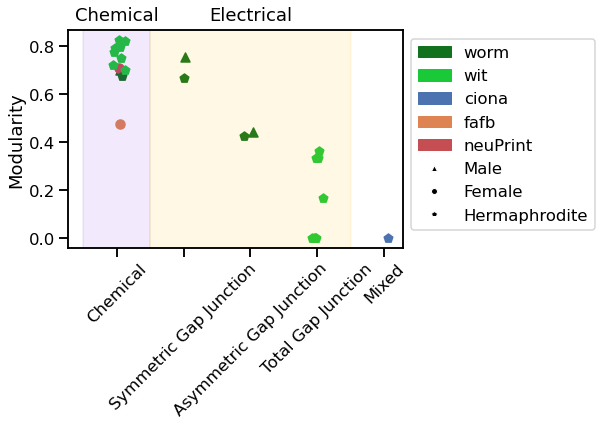

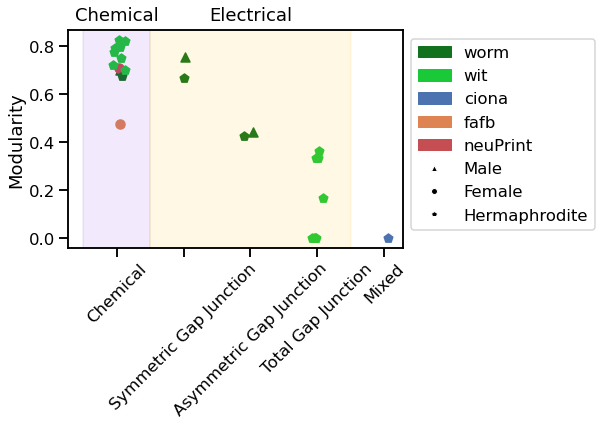

In [12]:
vis_stat(mod, "Modularity", use_log=False)